In [ ]:
import pandas as pd
from socube.t"r",ain import evaluateReport
from socube.utils import writeCsv, log, mkDirs

def ensemble(files:list):
    data = [pd.read_csv(file, header=None) for file in files ]
    return sum(data)/len(data)

def concencate(filenameFormat:str, start:int, end:int):
    columns = list(range(start, end+1))
    datas = [pd.read_csv(filenameFormat%idx, index_col=0) for idx in columns]
    datas.append(sum(datas)/len(datas))
    columns.append("mean")
    try:
        datas.append(pd.read_csv(filenameFormat%"Bagging", index_col=0))
        columns.append("Bagging")
    finally:
        datas = pd.concat(datas, axis=1)
        datas.columns = columns
        datas.index.name = "指标"
        return datas

In [ ]:
dataType="nuc-MULTI"
modelID="20220115-150149-915"
fold=5
threshold = 0.5

score = ensemble(f"outputs/{dataType}/{modelID}/test_score_{i+1}.csv" for i in range(fold))[0].values
label = pd.read_csv(f"datasets/{dataType}/ExperimentLabel.csv", header=None, index_col=0)[1].values

mkDirs(f"plots/{dataType}/{modelID}")
mkDirs(f"outputs/{dataType}/{modelID}")

log("inference", "Evaluating...")
report=evaluateReport(
        label, 
        score, 
        f"plots/{dataType}/{modelID}/test_roc_Bagging_{threshold}.png", 
        f"plots/{dataType}/{modelID}/test_prc_Bagging_{threshold}.png",
        threshold=threshold)
writeCsv(report, f"outputs/{dataType}/{modelID}/test_report_Bagging_{threshold}.csv")
writeCsv(score, f"outputs/{dataType}/{modelID}/test_score_Bagging.csv")
log("inference", "Finished...")
report

In [ ]:
val = concencate(f"outputs/{dataType}/{modelID}/test_report_%s_0.5.csv", 1, fold)
val.to_clipboard()
val

In [ ]:
import pandas as pd
import sklearn.metrics as metrics
import numpy as np

from socube.train import binaryRate

In [ ]:
def calPRT(
    dataset:str,
    modelID:str,
    idRate = 0.1,
    fold:int = 5):
    label = pd.read_csv(f"datasets/{dataset}/ExperimentLabel.csv", index_col=0, header=None).values.flatten()
    data = pd.DataFrame(dtype="float32", columns=["precision", "recall", "TNR"])
    for idx in range(1, fold + 1):
        score = pd.read_csv(f"outputs/{dataset}/{modelID}/test_score_{idx}.csv", header=None).values.flatten()
        k = int(idRate * len(score))
        r = len(score)-k
        theshold = np.partition(score, r)[r]
        predict = (score>=theshold).astype("int16")
        assert k == predict.sum().item()

        precision = metrics.precision_score(label, predict)
        recall = metrics.recall_score(label, predict)
        tpr,fnr,fpr,tnr = binaryRate(label, predict)
        data = data.append(pd.Series({
            "precision": precision,
            "recall": recall,
            "TNR": tnr,
            "TPR": tpr,
            "FNR": fnr,
            "FPR": fpr
        }, name=idx))
    
    mean = data.mean()
    mean.name = "mean"
    data = data.append(mean)
    return data

In [ ]:
calPRT(
    dataset= "pbmc-1A-dm",
    modelID= "20220221-175223-147"
)

## Feature visualization for Interpretation

In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath("src"))

import torch
import numpy as np
import pandas as pd
from socube.task.doublet import SoCubeNet, ConvClassifyDataset
from socube.utils import autoClearIter, loadTorchModule, writeCsv, writeNpy
from socube.data import umap2D, plotScatter
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from typing import List, Union
from glob import glob
from scipy.stats import entropy
from socube.cube import SoCube

In [ ]:
@torch.no_grad()
def getLatent(dataType:str, socubeId:str, netId:str, dataDir:str)->List[Union[np.ndarray, pd.DataFrame]]:
    dataset = ConvClassifyDataset(
        data_dir= os.path.join("internal_datasets",dataType, socubeId, dataDir),
        labels="ExperimentLabel.csv",
        shuffle=True,
        seed=4067,
        use_index=False
    )

    dataLoader = DataLoader(
        dataset=dataset,
        batch_size=400
    )
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = SoCubeNet(len(dataset[0]["data"]), 2 , binary=True).to(device)
    model =loadTorchModule(model, f"internal_models/{dataType}/{netId}/{SoCubeNet.__name__}_1.pt", skipped=False)
    itererate = autoClearIter(dataLoader)
    itererate = tqdm(itererate, desc="Validate")

    latents = []
    #labels = []
    for batch in itererate:
        data, label = batch.values()
        data = data.to(device)
        label = label.to(device)
        latent = model._feature(data)
        latents.append(latent)
        del data, label, latent

    latents = torch.cat(latents)
    #labels = torch.cat(labels)
    return latents.cpu().numpy(), dataset._labels

def getKL(data:pd.DataFrame, seed:int=None):
    mins = data.loc[:,"x":"y"].min()

    p = data[data.subtype=='doublet'].loc[:,"x":"y"]-mins + 1e-7
    q = data[data.subtype=='singlet'].loc[:,"x":"y"]-mins + 1e-7
    if len(p) > len(q):
        p, q = q, p
    q = q.sample(len(p), random_state=seed)
    
    return entropy(p.x, q.x), entropy(p.y, q.y)
    # data = data[data.subtypes=='doublet'].loc[:,"x":"y"]
    # return (data.std()/data.mean()).sum()

def getDistance(data:pd.DataFrame):
    doublet = data[data.subtype=='doublet'].loc[:,"x":"y"].mean()
    singlet = data[data.subtype=='singlet'].loc[:,"x":"y"].mean()
    return np.sqrt(np.square((singlet-doublet)/singlet).sum())


In [ ]:
dataset = "pbmc-1A-dm"
modelID = "20220314-163907-189"
cubeID = pd.read_csv(glob(f"internal_outputs/{dataset}/{modelID}/*_aveReport.csv")[0], index_col=0, header=None)
dataDir = cubeID.loc["data_dir"][1]
try:
    cubeID = cubeID.loc["socube"][1]
except KeyError as e:
    try:
        cubeID = cubeID.loc["scomap"][1]
    except KeyError as e:
        cubeID = dataDir.split("/")[-2]

dataDir = os.path.basename(dataDir)
metric="cosine"
typeMap = ["singlet", "doublet"]
print(cubeID)
print(dataDir)

In [ ]:
latents, labels = getLatent(
    dataType=dataset,
    socubeId=cubeID,
    netId=modelID,
    dataDir=dataDir)

In [ ]:
# writeNpy(latents, f"internal_outputs/{dataset}/{modelID}/latent_1.npy")

# latents2D = umap2D(pd.DataFrame(latents, index=labels.index), metric=metric)
# latents2D.index.name = "droplet"
# writeCsv(latents2D.loc[:,"x":"y"],  f"internal_outputs/{dataset}/{modelID}/latent_1_umap2D_{metric}.csv")
latents2D=pd.read_csv(f"internal_outputs/{dataset}/{modelID}/latent_1_umap2D_{metric}.csv", index_col=0)
labels=pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", index_col=0, header=None)

latents2D["label"] = latents2D.index
latents2D["subtype"] = labels[1].apply(lambda x: typeMap[x])
getDistance(latents2D)

In [ ]:
plotScatter(
    data2d=latents2D,
    colormap={
        "singlet":"#E6E6FA",
        "doublet":"#39547F"
        
    },
    title="Latent feature visualization",
    subtitle="By socube",
    scatter_symbol="circle",
    filename=f"internal_plots/{dataset}/{modelID}/latent_{metric}_1",
    radius=4,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    x_title="UMAP_1",
    y_title="UMAP_2"
)

In [ ]:
predictScore = pd.read_csv(f"outputs/{dataType}/{netId}/test_score_Bagging.csv", header=None)
# predictScore=pd.read_clipboard(index_col=0)
latents2D_predict = pd.read_csv(f"outputs/{dataType}/{netId}/latent_1_umap2D_{metric}.csv")
latents2D_predict["subtype"]=predictScore.iloc[:,0].values
latents2D_predict["label"]=latents2D_predict["subtype"]

In [ ]:
plotScatter(
    data2d=latents2D_predict,
    colormap={
        "doublet":"#39547F",
        "singlet":"#E48373"
        
    },
    title="Latent feature visualization",
    subtitle="By socube",
    filename=f"plots/{dataType}/{netId}/latent_{metric}_1_predict",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

In [ ]:
# rawData = pd.read_hdf(f"datasets/{dataType}/02-trainData[int16][raw+samples(1)].h5")
# rawData = rawData[rawData.apply(lambda x: not x.name.startswith("doublet"), axis=1)]
# raw2D = umap2D(rawData, metric=metric)
# writeCsv(raw2D.loc[:,"x":"y"],  f"outputs/{dataType}/{netId}/raw_umap2D_{metric}.csv")
raw2D=pd.read_csv(f"internal_outputs/{dataset}/{modelID}/raw_umap2D_{metric}.csv", index_col=0)
raw2D["label"]=raw2D.index
raw2D["subtype"]=latents2D["subtype"]
# getKL(raw2D)
getDistance(raw2D)

In [ ]:
plotScatter(
    data2d=raw2D,
    colormap={
        "singlet":"#E6E6FA",
        "doublet":"#39547F"
        
    },
    title="Latent feature visualization",
    subtitle="Raw data",
    scatter_symbol="circle",
    radius=4,
    filename=f"internal_plots/{dataset}/{modelID}/raw_{metric}",
    x_title="UMAP_1",
    y_title="UMAP_2"
)

## Intepretation visualization for Solo

In [ ]:
from socube.train import evaluateReport
dir=f"internal_outputs/solo_result/results_{dataset}[csc_sparse_matrix].h5ad_2020"
sololatent = np.load(f"{dir}/latent.npy")
soloscore = np.load(f"{dir}/softmax_scores.npy")
sololabel = pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", index_col=0, header=None)
sololatent = pd.DataFrame(sololatent, index=sololabel.index)
# sololatent2D = umap2D(sololatent, metric=metric)
# writeCsv(sololatent2D.loc[:,"x":"y"],  f"{dir}/latent_umap2D_{metric}.csv")
sololatent2D = pd.read_csv(f"{dir}/latent_umap2D_{metric}.csv", index_col=0)
sololatent2D["label"]=sololatent2D.index
sololatent2D["subtype"]=sololabel[1].apply(lambda x: typeMap[x])

In [ ]:
plotScatter(
    data2d=sololatent2D,
    colormap={
        "singlet":"#E6E6FA",
        "doublet":"#39547F"
        
    },
    title="Latent feature visualization",
    subtitle="By Solo",
    scatter_symbol="circle",
    radius=4,
    filename=f"{dir}/latent_umap2D_{metric}",
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    x_title="UMAP_1",
    y_title="UMAP_2"
)

In [ ]:
# getKL(sololatent2D)
getDistance(sololatent2D)

In [ ]:
# predictScore=pd.read_clipboard(index_col=0)
latents2D_solopredict = pd.read_csv(f"outputs/{dataType}/{netId}/latent_1_umap2D_{metric}.csv")
latents2D_solopredict["subtype"]=soloscore
latents2D_solopredict["label"]=latents2D_solopredict["subtype"]

In [ ]:
plotScatter(
    data2d=latents2D_solopredict,
    colormap={
        "doublet":"#39547F",
        "singlet":"#E48373"

        
    },
    title="Latent feature visualization",
    subtitle="By Solo",
    filename=f"{dir}/predict_umap2D_{metric}",
    radius=3,
    # xMin=-5,
    # xMax=15,
    # yMin=-6,
    # yMax=14,
    xTitle="UMAP_1",
    yTitle="UMAP_2"
)

## jaccard index

In [1]:
import pandas as pd

In [2]:
def create_cell_pairs(data: pd.DataFrame) -> set:
    cell_pairs = set()
    for name in data.iloc[:,0].unique():
        subType = data[data.iloc[:, 0] == name].index
        for i in range(len(subType) - 1):
            for j in range(i, len(subType)):
                cell_pair = "_".join(sorted([subType[i], subType[j]]))
                cell_pairs.add(cell_pair)
    return cell_pairs

def jaccard(data1: set, data2: set)->float:
    Intersection = len(data1.intersection(data2))
    return Intersection/(len(data1) + len(data2) - Intersection)

In [7]:
cell_type = pd.read_csv("../../internal_datasets/scPred_pbmc_1/cellType.csv", index_col=0)
cell_type_pairs = create_cell_pairs(cell_type)
cell_cluster_clean = pd.read_csv(r"outputs\scPred_pbmc_1\clean_cluster.csv", index_col=0)
cell_cluster_clean_pairs = create_cell_pairs(cell_cluster_clean)
print("Jaccard index of Control compared with true type", jaccard(cell_type_pairs, cell_cluster_clean_pairs))
cell_cluster_socube = pd.read_csv("outputs/scPred_pbmc_1/20220416-172623-141/cluster.csv", index_col=0)
cell_cluster_socube_pairs = create_cell_pairs(cell_cluster_socube)
print("Jaccard index of SoCube compared with true type", jaccard(cell_type_pairs, cell_cluster_socube_pairs))
print("Jaccard index of SoCube compared with Control", jaccard(cell_cluster_clean_pairs, cell_cluster_socube_pairs))
cell_cluster_solo = pd.read_csv(r"outputs\solo_result\scPred_pbmc_1_2010\cluster.csv", index_col=0)
cell_cluster_solo_pairs = create_cell_pairs(cell_cluster_solo)
print("Jaccard index of Solo compared with true type", jaccard(cell_cluster_solo_pairs, cell_type_pairs))
print("Jaccard index of Solo compared with Control", jaccard(cell_cluster_clean_pairs, cell_cluster_solo_pairs))
cell_cluster_df = pd.read_csv(r"outputs\doubletfinder_result\scPred_pbmc_1\cluster.csv", index_col=0)
cell_cluster_df_pairs = create_cell_pairs(cell_cluster_df)
print("Jaccard index of DF compared with true type", jaccard(cell_type_pairs, cell_cluster_df_pairs))
print("Jaccard index of DF compared with Control", jaccard(cell_cluster_clean_pairs, cell_cluster_df_pairs))
cell_cluster_scdbl = pd.read_csv("../../internal_outputs/scDblFinder_result/scPred_pbmc_1/cluster.csv", index_col=0)
cell_cluster_scdbl_pairs = create_cell_pairs(cell_cluster_scdbl)
print("Jaccard index of scdbl compared with true type", jaccard(cell_type_pairs, cell_cluster_scdbl_pairs))
cell_cluster_dir = pd.read_csv("../../internal_outputs/scPred_pbmc_1/dir_cluster.csv", index_col=0)
cell_cluster_dir_pairs = create_cell_pairs(cell_cluster_dir)
print("Jaccard index of scdbl compared with true type", jaccard(cell_type_pairs, cell_cluster_dir_pairs))

## scWGCNA for Interpretation

In [1]:
import pandas as pd
from socube.data import plotGrid
from socube.utils import ParallelManager, Redirect, checkExist, getJobId
from typing import Optional
BASE_DIR = "datasets"
def build(dataset: str,
          jobid: Optional[str] = None,
          dataFile: Optional[str] = None,
          k: int = 10):
    with ParallelManager():
        print("Training socube...")
        myMap = SoCube.instance(map_type="pca",
                                dataPath=f"{BASE_DIR}/{dataset}",
                                modelPath=f"models/{dataset}",
                                plotPath=f"plots/{dataset}",
                                verbose=0)
        if jobid is None:
            checkExist(f"{BASE_DIR}/{dataset}/{dataFile}")
            print("No jobid specific, try to train a new socube")
            jobid = getJobId()
            with Redirect(f"{BASE_DIR}/{dataset}/{jobid}/log.txt",
                          verbose=False):
                myMap.fit(dataFile, jobId=jobid, k=k)
        else:
            print("Load default socube...")
            myMap.grid = pd.read_csv(
                f"{BASE_DIR}/{dataset}/{jobid}/data[log+std+norm+umap+jv].csv",
                index_col=0)
            myMap.latent = pd.read_hdf(
                f"{BASE_DIR}/{dataset}/{jobid}/latent[log+std+norm].h5")
        return jobid, myMap

In [ ]:
dataset = "pbmc-1A-dm"
socubeId = "20220115-174928-553"
_, cube = build(dataset, socubeId)
co_gene = pd.read_csv(f"outputs/{dataset}/co-expression-gene[{socubeId}].csv", index_col=0)
grid = cube.grid.join(co_gene)
grid["module"].fillna("other", inplace=True)
grid["label"] = grid.index
grid.columns = ["x", "y", "subtype", "label"]
plotGrid(
    data2d=grid,
    colormap={
        "module_1": "#DB7093",
        "module_4": "#9370DB",
        "module_3": "#6A5ACD",
        "module_2": "#F0FFFF",
        "module_5": " #FFDEAD",
        "other": "#F8F8FF"
    },
    shape=cube.shape,
    title=f"WGCNA on {dataset}",
    subtitle="UMAP based",
    filename=f"plots/{dataset}/WGCNA[{socubeId}]"
)

## Benchmark analysis

In [1]:
%cd ../../

d:\life_matters\IDRB\深度组学\单细胞组学\internal-socube


In [8]:
import pandas as pd

from socube.train.metrics import evaluateReport

In [40]:
benchmark_datasets = [
    # "pbmc-ch",
    # "cline-ch",
    # "mkidney-ch",
    # "pbmc-1A-dm",
    # "pbmc-1B-dm",
    # "pbmc-1C-dm",
    # "pbmc-2ctrl-dm",
    # "pbmc-2stim-dm",
    # "J293t-dm",
    # "pdx-MULTI",
    # "HMEC-orig-MULTI",
    # "HMEC-rep-MULTI",
    # "HEK-HMEC-MULTI",
    # "nuc-MULTI",
    "hm-6k",
    "hm-12k"
]
index = pd.Series(benchmark_datasets)

### for scDblFinder

In [13]:
def evaluate(dataset: str):
    real_label = pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", header=None, index_col=0)
    pred_label = pd.read_csv(f"internal_outputs/scDblFinder_result/{dataset}/score.csv", index_col=0)
    res = evaluateReport(
        real_label.iloc[:,0], 
        pred_label.iloc[:,0],
        f"internal_outputs/scDblFinder_result/{dataset}/roc.pdf",
        f"internal_outputs/scDblFinder_result/{dataset}/prc.pdf",
        )
    res.name = dataset
    return res

In [19]:
result = index.apply(evaluate)
result.index = index

In [20]:
result

,ACC,MCC,AP,binary_AUROC,binary_AUPRC,binary_F1,binary_precision,binary_recall
pbmc-ch,0.893727,0.587555,0.632411,0.828529,0.632230,0.643218,0.730040,0.574853
cline-ch,0.835429,0.318342,0.425598,0.620067,0.425483,0.341880,0.648855,0.232082
mkidney-ch,0.698853,0.317040,0.604713,0.703662,0.604638,0.439346,0.719137,0.316289
pbmc-1A-dm,0.941783,0.457176,0.492437,0.819310,0.488157,0.457627,0.346154,0.675000
pbmc-1B-dm,0.941689,0.427763,0.436513,0.782753,0.434473,0.428941,0.322957,0.638462
pbmc-1C-dm,0.939658,0.560692,0.603338,0.848511,0.602485,0.582677,0.497758,0.702532
pbmc-2ctrl-dm,0.927262,0.688685,0.670938,0.926965,0.670239,0.722740,0.642788,0.825407
pbmc-2stim-dm,0.926847,0.685284,0.671910,0.923632,0.671574,0.721554,0.651358,0.808706
J293t-dm,0.870000,0.127011,0.209938,0.553389,0.204264,0.197531,0.205128,0.190476
pdx-MULTI,0.863248,0.368939,0.420359,0.724193,0.419877,0.446541,0.462918,0.431283


### for DoubletFinder

In [29]:
import glob
def evaluate(dataset: str):
    real_label = pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", header=None, index_col=0)
    pred_label = pd.read_csv(f"internal_outputs/doubletfinder_result/{dataset}_*/score.csv", index_col=0)
    res = evaluateReport(
        real_label.iloc[:,0], 
        pred_label.iloc[:,0],
        f"internal_outputs/doubletfinder_result/{dataset}/roc.pdf",
        f"internal_outputs/doubletfinder_result/{dataset}/prc.pdf",
        )
    res.name = dataset
    return res
result = index.apply(evaluate)
result.index = index

In [31]:
result

,ACC,MCC,AP,binary_AUROC,binary_AUPRC,binary_F1,binary_precision,binary_recall
pbmc-ch,0.877423,0.489679,0.604931,0.839575,0.606746,0.527034,0.738146,0.409823
cline-ch,0.824868,0.200571,0.381792,0.588161,0.382541,0.094867,0.986486,0.049829
mkidney-ch,0.628358,0.042033,0.460572,0.572679,0.460552,0.010808,0.767857,0.005442
pbmc-1A-dm,0.961795,0.517150,0.475861,0.839860,0.489228,0.533333,0.480000,0.600000
pbmc-1B-dm,0.947757,0.325783,0.230353,0.740966,0.228713,0.348684,0.304598,0.407692
pbmc-1C-dm,0.952751,0.572794,0.527565,0.837942,0.540702,0.597738,0.610561,0.585443
pbmc-2ctrl-dm,0.912456,0.510697,0.601278,0.901788,0.601289,0.545522,0.675601,0.457447
pbmc-2stim-dm,0.925481,0.620184,0.642115,0.911163,0.644971,0.659888,0.709450,0.616800
J293t-dm,0.922000,0.270754,0.225276,0.559550,0.231430,0.204082,0.714286,0.119048
pdx-MULTI,0.885101,0.360300,0.387752,0.708174,0.394229,0.382890,0.611667,0.278664


### for Solo

In [43]:
def evaluate(dataset: str):
    real_label = pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", header=None, index_col=0)
    pred_label_dir = glob(f"internal_outputs/solo_result/{dataset}_*")[0]
    pred_label = pd.read_csv(f"{pred_label_dir}/softmax_scores.csv", header=None)
    res = evaluateReport(
        real_label.iloc[:,0], 
        pred_label.iloc[:,0],
        f"internal_outputs/doubletfinder_result/{dataset}/roc.pdf",
        f"internal_outputs/doubletfinder_result/{dataset}/prc.pdf",
        )
    res.name = dataset
    return res
result = index.apply(evaluate)
result.index = index

## Benchmark analysis by cell library size

In [2]:
import pandas as pd
import numpy as np
from socube.train import evaluateReport
from anndata import read_h5ad
from warnings import filterwarnings
from sklearn.exceptions import UndefinedMetricWarning

filterwarnings("ignore", category=UndefinedMetricWarning)

In [3]:
def split(data: pd.DataFrame, n_bins: int) -> pd.DataFrame:
    """
    Split the data into n_bins bins
    """
    bin_size = int(np.around(len(data) / n_bins))
    start_index = 0
    for bin_idx in range(n_bins):
        res = (data.iloc[start_index : start_index + bin_size] if bin_idx < n_bins -1  else data.iloc[start_index:]).copy()
        start_index += bin_size
        yield res

In [137]:
dataset_dict = {
    "pbmc-ch": "internal_outputs/pbmc-ch/20220113-180008-152",
    # "cline-ch": "internal_outputs/cline-ch/20220313-051423-386",
    # "mkidney-ch": "internal_outputs/mkidney-ch/20220313-061616-949",
    # "pbmc-1A-dm": "internal_outputs/pbmc-1A-dm/20220314-163907-189",
    # "pbmc-1B-dm": "internal_outputs/pbmc-1B-dm/20220313-002301-304",
    # "pbmc-1C-dm": "internal_outputs/pbmc-1C-dm/20220702-130505-840",
    # "pbmc-2ctrl-dm": "internal_outputs/pbmc-2ctrl-dm/20220314-162706-113",
    # "pbmc-2stim-dm": "internal_outputs/pbmc-2stim-dm/20220313-005553-685",
    # "J293t-dm": "internal_result/reproduce/J293t-dm/outputs/20221007-103259-708", # NaN for solo
    # "pdx-MULTI": "internal_outputs/pdx-MULTI/20220312-223936-683",
    # "HMEC-orig-MULTI": "internal_outputs/HMEC-orig-MULTI/20220313-015830-683",
    # "HMEC-rep-MULTI": "internal_result/reproduce/HMEC-rep-MULTI/outputs/20221007-134705-218",
    # "HEK-HMEC-MULTI": "internal_result/reproduce/HEK-HMEC-MULTI/outputs/20221007-003415-717",
    # "nuc-MULTI": "internal_result/reproduce/nuc-MULTI/outputs/20221007-105329-530",
    # "hm-6k": "internal_result/reproduce/hm-6k/outputs/20221006-201050-775",
    # "hm-12k": "internal_result/reproduce/hm-12k/outputs/20221006-220638-939"
}
for dataset, socube_dir in dataset_dict.items():
    try:
        socube_score = pd.read_csv(f"{socube_dir}/test_score_Bagging.csv", header=None).iloc[:,0].values
    except FileNotFoundError as e:
        socube_score= pd.read_csv(f"{socube_dir}/final_result_0.5.csv")["predict_score"].values
    
    solo_score = np.load(f"internal_outputs/solo_result/results_{dataset}[csc_sparse_matrix].h5ad_2020/softmax_scores.npy")
    # solo_score = np.full_like(socube_score, np.NAN)
    df_score = pd.read_csv(f"internal_outputs/doubletfinder_result/{dataset}/score.csv", index_col=0)["x"].values
    # df_score = np.full_like(socube_score, np.NAN)
    scdbl_score = pd.read_csv(f"internal_outputs/scDblFinder_result/{dataset}/score.csv", index_col=0)["x"].values
    result = pd.read_csv(f"internal_datasets/{dataset}/ExperimentLabel.csv", index_col=0, header=None)
    assert len(result) == len(socube_score)
    result["socube"] = socube_score
    result["solo"] = solo_score
    result["df"] = df_score
    result["scdbl"] = scdbl_score
    result.columns = ["label", "socube", "solo", "df", "scdbl"]
    result.index.name = "gene"
    data = read_h5ad(f"internal_datasets/PMID33338399/real_datasets_sparse/{dataset}[csc_sparse_matrix].h5ad")
    result["size"] = pd.DataFrame(data.X.sum(axis=1))[0].values
    result = result.sort_values("size")
    del data, socube_score, solo_score, df_score, scdbl_score

    data = [pd.DataFrame(columns="ACC,MCC,AP,binary_AUROC,binary_AUPRC,binary_F1,binary_precision,binary_recall".split(",")) for _ in range(4)]

    for idx, sub in enumerate(split(result, 10), 1):
        data[0].loc[idx] = evaluateReport(
                sub["label"].values, 
                sub["socube"].values,
                f"{socube_dir}/roc_library_part_{idx}.pdf",
                f"{socube_dir}/prc_library_part_{idx}.pdf",)

        data[1].loc[idx] = evaluateReport(
                sub["label"].values, 
                sub["solo"].values,
                f"internal_outputs/solo_result/results_{dataset}[csc_sparse_matrix].h5ad_2020/roc_library_part_{idx}.pdf",
                f"internal_outputs/solo_result/results_{dataset}[csc_sparse_matrix].h5ad_2020/prc_library_part_{idx}.pdf")
        data[2].loc[idx] = evaluateReport(
                sub["label"].values, 
                sub["df"].values,
                f"internal_outputs/doubletfinder_result/{dataset}/roc_library_part_{idx}.pdf",
                f"internal_outputs/doubletfinder_result/{dataset}/prc_library_part_{idx}.pdf")
        data[3].loc[idx] = evaluateReport(
                sub["label"].values, 
                sub["scdbl"].values,
                f"internal_outputs/scDblFinder_result/{dataset}/roc_library_part_{idx}.pdf",
                f"internal_outputs/scDblFinder_result/{dataset}/prc_library_part_{idx}.pdf")
    
    data[0].to_csv(f"{socube_dir}/report_by_szie.csv")
    data[1].to_csv(f"internal_outputs/solo_result/{dataset}_report_by_szie.csv")
    data[2].to_csv(f"internal_outputs/doubletfinder_result/{dataset}_report_by_szie.csv")
    data[3].to_csv(f"internal_outputs/scDblFinder_result/{dataset}_report_by_szie.csv")

In [138]:
AUPRC_result = pd.concat([dat["binary_AUPRC"] for dat in data], axis = 1)
AUPRC_result.columns = ["SoCube", "Solo", "DoubletFinder", "scDblFinder"]
AUPRC_result

,SoCube,Solo,DoubletFinder,scDblFinder
1,0.200427,0.089858,0.218187,0.131040
2,0.147256,0.060792,0.127891,0.104984
3,0.163357,0.096551,0.166156,0.094348
4,0.207486,0.192092,0.219730,0.186371
5,0.150535,0.184666,0.160124,0.112745
6,0.234321,0.250094,0.254702,0.262917
7,0.425168,0.404091,0.359413,0.381524
8,0.653259,0.570474,0.543175,0.580252
9,0.762792,0.738496,0.710940,0.726132
10,0.864094,0.815053,0.784320,0.848979


In [114]:
AUPRC_result.to_clipboard()

In [139]:
AUROC_result = pd.concat([dat["binary_AUROC"] for dat in data], axis = 1)
AUROC_result.columns = ["SoCube", "Solo", "DoubletFinder", "scDblFinder"]
AUROC_result

,SoCube,Solo,DoubletFinder,scDblFinder
1,0.605945,0.517407,0.659184,0.531125
2,0.601699,0.595542,0.609889,0.567182
3,0.639539,0.615790,0.650671,0.559271
4,0.676359,0.694676,0.702152,0.609346
5,0.637807,0.689176,0.690369,0.541151
6,0.699015,0.767129,0.747308,0.686036
7,0.751967,0.771992,0.774778,0.734613
8,0.874194,0.855091,0.824245,0.838529
9,0.874781,0.840992,0.818452,0.846827
10,0.875034,0.813701,0.781959,0.851740


In [116]:
AUROC_result.to_clipboard()

In [121]:
total = pd.read_clipboard()

In [135]:
total.drop("bin_idx", axis=1).groupby(["dataset"]).mean()

,SoCube,Solo,DoubletFinder,scDblFinder,SoCube.1,Solo.1,DoubletFinder.1,scDblFinder.1
dataset,,,,,,,,
HEK-HMEC-MULTI,0.270820,0.099038,0.253399,0.274266,0.697709,0.598183,0.623853,0.676265
HMEC-orig-MULTI,0.296705,0.308667,0.288371,0.366786,0.680853,0.689437,0.662446,0.696537
HMEC-rep-MULTI,0.544981,0.533037,0.522304,0.459320,0.705599,0.698285,0.673974,0.635246
J293t-dm,0.319940,NaN,0.313695,0.291289,0.643884,NaN,0.640616,0.628734
cline-ch,0.381512,0.352826,0.349633,0.386556,0.649517,0.618925,0.584845,0.618887
hm-12k,0.802294,0.303791,0.921124,0.939005,0.997211,0.928031,0.997816,0.996049
hm-6k,0.797185,0.542735,0.898814,0.860758,0.999024,0.978291,0.999404,0.999048
mkidney-ch,0.587975,0.605453,0.369659,0.544289,0.712643,0.741610,0.473861,0.685453
nuc-MULTI,0.296428,0.215849,0.276802,0.245564,0.729997,0.666024,0.672787,0.651002


In [136]:
total.groupby(["bin_idx"]).mean()

,SoCube,Solo,DoubletFinder,scDblFinder,SoCube.1,Solo.1,DoubletFinder.1,scDblFinder.1
bin_idx,,,,,,,,
1,0.146373,0.127909,0.155690,0.218319,0.593582,0.584276,0.575118,0.571165
2,0.218263,0.155158,0.209458,0.243898,0.609049,0.626524,0.596998,0.632473
3,0.238379,0.209943,0.237062,0.281590,0.676306,0.667766,0.606242,0.634047
4,0.296652,0.242863,0.275274,0.344994,0.681942,0.696799,0.635367,0.654254
5,0.322766,0.224281,0.279192,0.302752,0.700526,0.694875,0.672917,0.664000
6,0.338310,0.277530,0.372657,0.384084,0.757924,0.730698,0.714016,0.719850
7,0.465471,0.351875,0.416698,0.475245,0.764933,0.772300,0.741128,0.760337
8,0.561162,0.436355,0.477514,0.510501,0.790556,0.778004,0.745110,0.775975
9,0.697205,0.553397,0.632876,0.703620,0.868085,0.821220,0.823537,0.864629


## Different simulated doublet generation mode

In [78]:
import scanpy as sc
import pandas as pd

import matplotlib.pyplot as plt
from socube.task.doublet.data import generateDoublet
from warnings import filterwarnings

filterwarnings('ignore', category=FutureWarning)
%matplotlib inline

In [3]:
%cd ../..

d:\life_matters\IDRB\深度组学\单细胞组学\internal-socube


In [117]:
plt.style.use("seaborn-white")
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
data = sc.read_h5ad("internal_datasets/hm-6k/hm-6k[csc_sparse_matrix].h5ad")

In [ ]:
sc.pp.neighbors(data, n_neighbors=10, n_pcs=50)
sc.tl.umap(data)

In [112]:
singlets, doublets = generateDoublet(data.to_df(), mode="heterotypic")
doublets = sc.AnnData(doublets, obs=pd.DataFrame(index=doublets.index, columns=["type"], data="sim_doublet"))
hetero = sc.concat([data[data.obs.type=="singlet"], doublets, data[data.obs.type=="doublet"]])
sc.pp.neighbors(hetero, n_neighbors=10, n_pcs=50)
sc.tl.umap(hetero)

2022-10-09 16:53:36,785 - Generate - INFO - Generating doublet with mode: heterotypic


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [113]:
singlets, doublets = generateDoublet(data.to_df(), mode="homotypic")
doublets = sc.AnnData(doublets, obs=pd.DataFrame(index=doublets.index, columns=["type"], data="sim_doublet"))
homo = sc.concat([data[data.obs.type=="singlet"], doublets, data[data.obs.type=="doublet"]])
sc.pp.neighbors(homo, n_neighbors=10, n_pcs=50)
sc.tl.umap(homo)

2022-10-09 16:54:02,331 - Generate - INFO - Generating doublet with mode: homotypic


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [107]:
singlets, doublets = generateDoublet(data.to_df(), mode="balance")
doublets = sc.AnnData(doublets, obs=pd.DataFrame(index=doublets.index, columns=["type"], data="sim_doublet"))
balance =  sc.concat([data[data.obs.type=="singlet"], doublets, data[data.obs.type=="doublet"]]) # data.concatenate(doublets) #
sc.pp.neighbors(balance, n_neighbors=10, n_pcs=50)
sc.tl.umap(balance)

2022-10-09 16:47:35,954 - Generate - INFO - Generating doublet with mode: balance


         Falling back to preprocessing with `sc.pp.pca` and default params.


In [109]:
colors = {
    "real_doublet": '#39547F',
    "stim_doublet": '#DB7093',
    "singlet": '#E6E6FA'
}

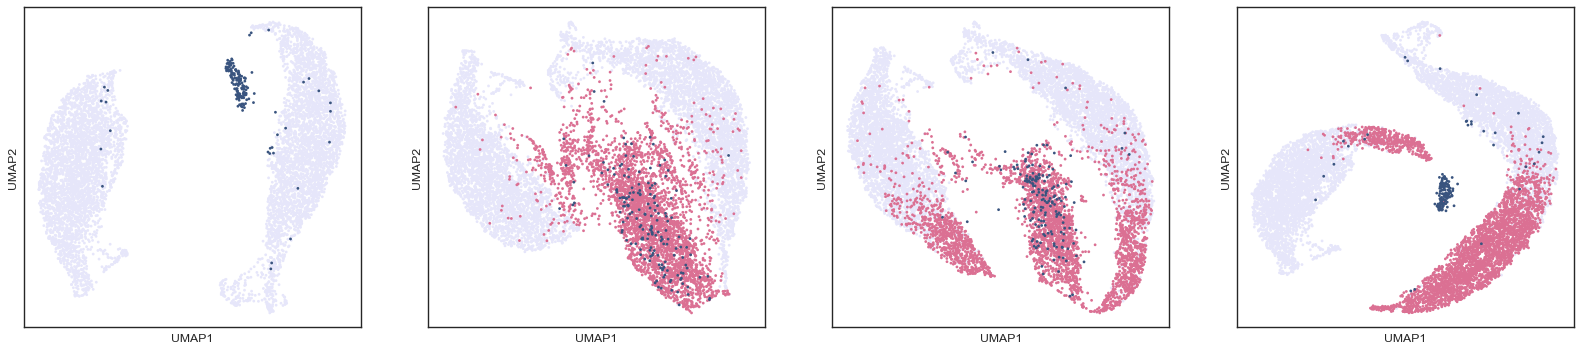

In [118]:
fig, axs = plt.subplots(1, 4, figsize = (25, 5))
sc.pl.umap(data, color=["type"], palette=[colors['real_doublet'], colors['singlet']], ax=axs[0], show=False, title="", legend_loc=None, size=25)
sc.pl.umap(hetero, color=["type"], palette=[colors['real_doublet'], colors['stim_doublet'], colors['singlet']], show=False, ax=axs[1], title="", legend_loc=None, size=25)
sc.pl.umap(balance, color=["type"], palette=[colors['real_doublet'], colors['stim_doublet'], colors['singlet']], show=False, ax=axs[2],  title="", legend_loc=None, size=25)
sc.pl.umap(homo, color=["type"], palette=[colors['real_doublet'], colors['stim_doublet'], colors['singlet']], show=False, ax=axs[3],  title="", legend_loc=None, size=25)
plt.savefig("materials/figures/Figure.4A.stim-mode.pdf")